<a href="https://colab.research.google.com/github/leong2009/App/blob/main/Copy_of_deepfakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
from torchvision import transforms, datasets, models
from gdown import download
from zipfile import ZipFile
from PIL import Image
import torch.optim as optim

# 1. Κατεβάζουμε όλες τις εικόνες

In [ ]:
def download_and_extract(id, filename, extracted_folder):
    # Κατεβάστε το αρχείο zip εάν δεν υπάρχει ήδη
    if not os.path.exists(filename):
        print("Γίνεται φόρτωση του αρχείου",filename)
        download(id=id, output=filename, quiet=False)

    # Εξαγωγή του αρχείου zip εάν ο φάκελος δεν υπάρχει ήδη
    if not os.path.exists(extracted_folder):
        print("Γίνεται αποσυμπίεση των αρχείων...")
        with ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
main_folder = "deepfakes"
download_and_extract('16vuZcaQbd6Mmr4QZgKHJ_Y9UolOef12z', "deepfakes.zip", main_folder)

Γίνεται φόρτωση του αρχείου deepfakes.zip


Downloading...
From (original): https://drive.google.com/uc?id=16vuZcaQbd6Mmr4QZgKHJ_Y9UolOef12z
From (redirected): https://drive.google.com/uc?id=16vuZcaQbd6Mmr4QZgKHJ_Y9UolOef12z&confirm=t&uuid=cd3d16c9-4c06-48af-b3dd-33d6c7212035
To: /content/deepfakes.zip
100%|██████████| 131M/131M [00:01<00:00, 84.3MB/s]


Γίνεται αποσυμπίεση των αρχείων...


# 2. Δημιουργούμε τα Datasets

Ορίζουμε τα train και validation Dataset και τους αντίστοιχους DataLoader

In [ ]:
train_folder = os.path.join(main_folder, "train")
validation_folder = os.path.join(main_folder, "validation")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Train dataset size: 40000
Validation dataset size: 2000


# 3. Ορίζουμε το μοντέλο προς εκπαίδευση

**ΣΗΜΑΝΤΙΚΟ!!**

Για την άσκηση πρέπει να χρησιμοποιήσετε υποχρεωτικά το μοντέλο `shufflenet_v2_x1_0` από τα μοντέλα της `torchvision`

In [ ]:
model = models.shufflenet_v2_x1_0(num_classes = 2)

if True:
    # Προαιρετικά: το αρχικοποιούμε προ-εκπαιδευμένο με βάση το ImageNet
    model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    # Καθώς το imagenet έχει 1000 κατηγορίες τις αλλάζουμε σε 2
    model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()
model.to(device);

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 38.6MB/s]


# 4. Εκπαιδεύστε το μοντέλο

Για μεγαλύτερη ταχύτητα επιλέξτε στο Colab τη χρήση GPU π.χ. T4

In [ ]:
# Loss+Adam(βελτιστοποιηση)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 50

best_val_loss = float("inf")  # watch model

for epoch in range(num_epochs):
    model.train()  # model
    train_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)
#val
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(validation_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Αποθήκευση του καλύτερου μοντέλου
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("best saved")

print("edu done")

Epoch 1/10 - Train Loss: 0.1645, Train Acc: 93.70% - Val Loss: 0.1218, Val Acc: 95.05%
best saved
Epoch 2/10 - Train Loss: 0.1102, Train Acc: 95.89% - Val Loss: 0.1413, Val Acc: 94.30%
Epoch 3/10 - Train Loss: 0.0851, Train Acc: 96.90% - Val Loss: 0.1510, Val Acc: 93.60%
Epoch 4/10 - Train Loss: 0.0664, Train Acc: 97.51% - Val Loss: 0.1932, Val Acc: 93.85%
Epoch 5/10 - Train Loss: 0.0546, Train Acc: 97.97% - Val Loss: 0.1127, Val Acc: 95.35%
best saved
Epoch 6/10 - Train Loss: 0.0481, Train Acc: 98.22% - Val Loss: 0.1261, Val Acc: 95.15%
Epoch 7/10 - Train Loss: 0.0380, Train Acc: 98.60% - Val Loss: 0.1290, Val Acc: 95.50%
Epoch 8/10 - Train Loss: 0.0380, Train Acc: 98.62% - Val Loss: 0.1176, Val Acc: 95.85%
Epoch 9/10 - Train Loss: 0.0327, Train Acc: 98.78% - Val Loss: 0.1443, Val Acc: 95.30%
Epoch 10/10 - Train Loss: 0.0307, Train Acc: 98.88% - Val Loss: 0.1536, Val Acc: 94.85%
edu done


# 5. Εξαγωγή των βαρών

Σώστε τα βάρη του νευρωνικού ως `.png` εικόνα και ανεβάστε την εικόνα στο site για υποβολή.

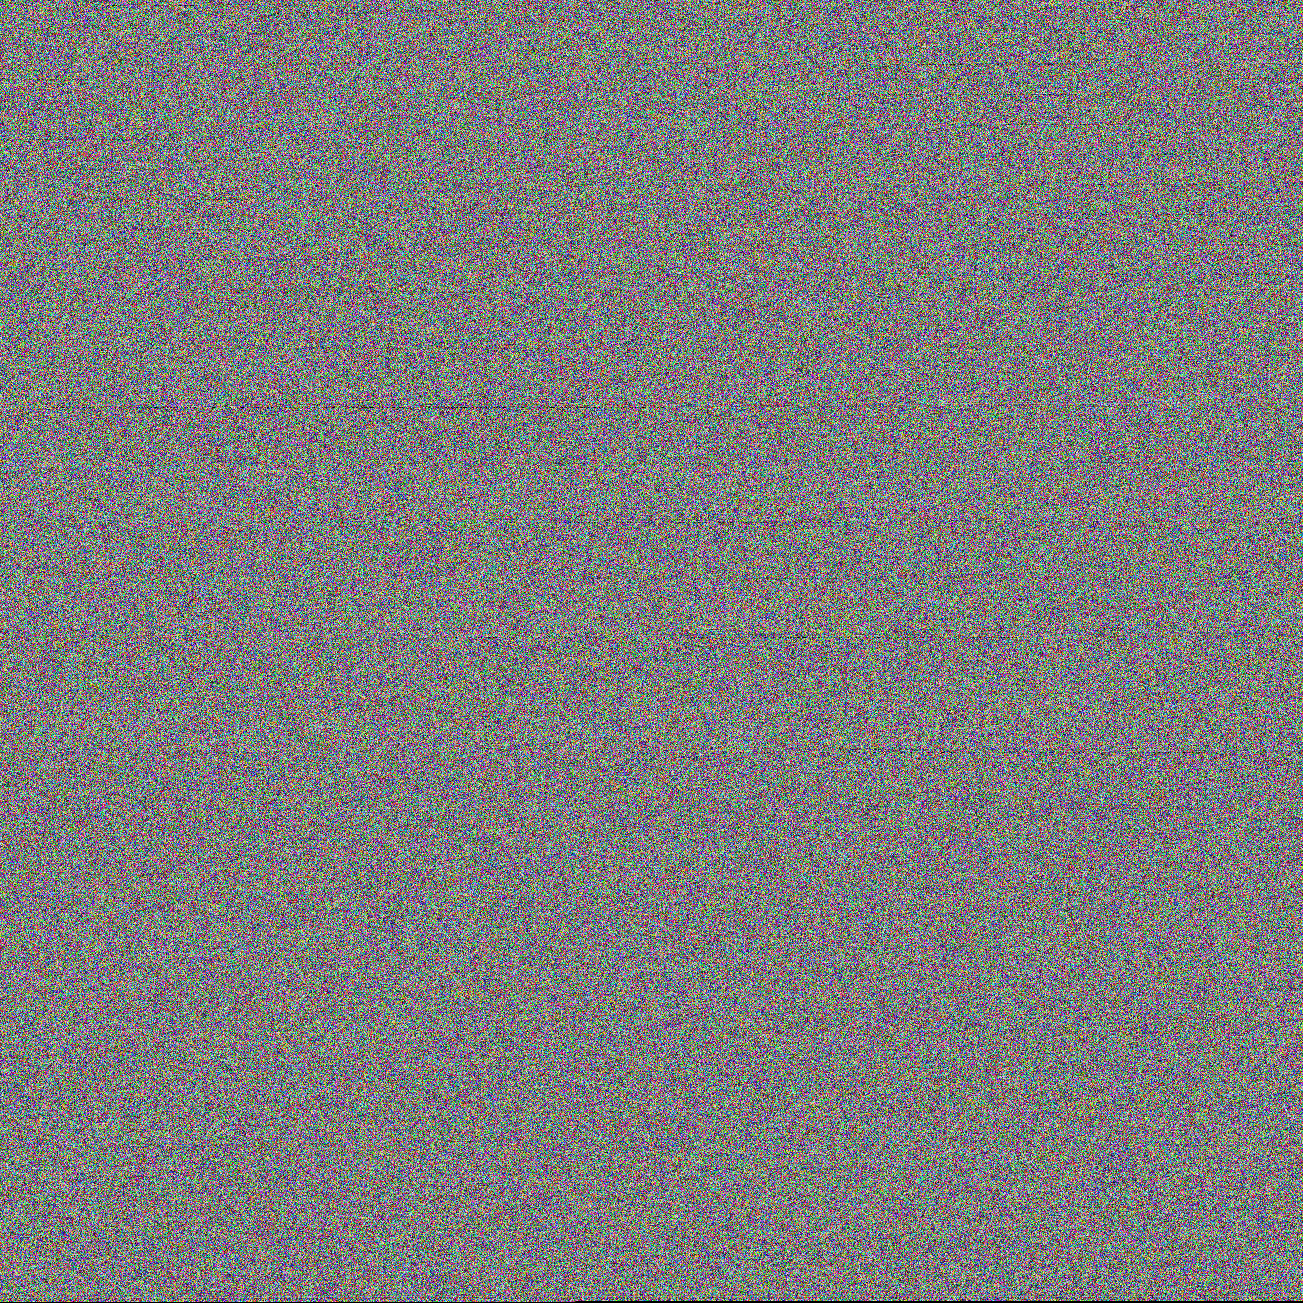

In [ ]:
def modelToImage(model):
    model.eval()
    state_dict = model.state_dict()
    weights = []
    for key, tensor in state_dict.items():
        if 'num_batches_tracked' in key: continue
        w = tensor.flatten().cpu().numpy()
        weights.append(w)
    weights = np.concatenate(weights).astype(np.float32)
    byte_array = weights.view(np.uint8)
    L = len(byte_array) / 3
    N = int( np.ceil( np.sqrt(L) ) )
    padding = 3*N*N - len(byte_array)
    byte_array = np.pad(byte_array, (0, padding), mode='constant')
    img = Image.fromarray(byte_array.reshape(N,N,3).astype(np.uint8), mode='RGB')
    img.save("weights.png")
    return img

modelToImage(model)